# CVX Project - Part 2 | Spring 2019
### Importing the major functions 

In [1]:
import mne
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.inverse_sparse import mixed_norm
from mne.viz import (plot_sparse_source_estimates,
                     plot_dipole_locations, plot_dipole_amplitudes)
import matplotlib.pyplot as plt

First we consider the comparative times of convergence of different methods in solving **Source Localization in the inverse problem using output of non-invasive sensors on the brain**.
There is a trade-off between accuracy and speed. The goal is to speed up this process
for online diagnosis. The advantage of this approach is 3-fold:
1. it is spatio-temporal **without assuming stationarity** (sources properties can vary over time)
2. activations are localized in space, time and frequency in one step
3. the solver solves a convex optimization problem, hence cannot be trapped in local minima

Code is anotated in the file as required.

### Some Citations

.. [1] A. Gramfort, D. Strohmeier, J. Haueisen, M. Hamalainen, M. Kowalski "Time-Frequency Mixed-Norm Estimates: Sparse M/EEG imaging with non-stationary source activations", Neuroimage, Volume 70, pp. 410-422, 15 April 2013. DOI: 10.1016/j.neuroimage.2012.12.051

.. [2] Strohmeier D., Haueisen J., and Gramfort A. "Improved MEG/EEG source localization with reweighted mixed-norms", 4th International Workshop on Pattern Recognition in Neuroimaging, Tuebingen, 2014. 10.1109/PRNI.2014.6858545

### Importing Sample Data and Trimming the Epochs of Each Event - Includes:
1. Isolating channel and defining an event trigger
2. Capturing 100ms before to 400ms after the event
3. Capture baseline from the earlier samples before t = 0
4. Reject extraneous sensor values across epochs
5. Source and list epochs


In [2]:
data_path = sample.data_path()
subjects_dir = data_path + '/subjects'
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'
ave_fname = data_path + '/MEG/sample/sample_audvis-no-filter-ave.fif'
cov_fname = data_path + '/MEG/sample/sample_audvis-shrunk-cov.fif'

1. fwd.fif contains the gain matrix as desribed in the papers cited
2. ave.fif contains the actual sensor data
3. cov.fif contains the covariance matrix to find the ideal weights of each sensor

In [3]:
print fwd_fname

/Users/pavan/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif


The raw data is now read and the epochs for left visual stimulus to the brain are stored as an object of lists. The baseline readings are not considered and the data of the stimuli are considered a little before and a little after the epoch. Each **channel** refers to a sensor.

### Extracting the Gain Matrix for M/EEG data

In [4]:
cov = mne.read_cov(cov_fname)
condition = 'Left visual'
evoked = mne.read_evokeds(ave_fname, condition=condition, baseline=(None, 0))
evoked = mne.pick_channels_evoked(evoked)
evoked.crop(tmin=-0.1, tmax=0.4)
forward = mne.read_forward_solution(fwd_fname)

    365 x 365 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 59) active
Reading /Users/pavan/mne_data/MNE-sample-data/MEG/sample/sample_audvis-no-filter-ave.fif ...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -199.80 ...     499.49 ms (Left visual)
        0 CTF compensation matrices available
        nave = 64 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Reading forward solution from /Users/pavan/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added..

I will now attempt to display the actual Gain Matrix from the above fwd.fif file. The gain matrix can also be approximated in many ways but we assume in this example for it to exist. This refers to the mapping between source data and the sensor output. Note: This is NOT the same as weighting the features for regularization. Also note that both MEG and EEG data has a Gain Matrix. Generally the O/P of both are fused (complementary features).

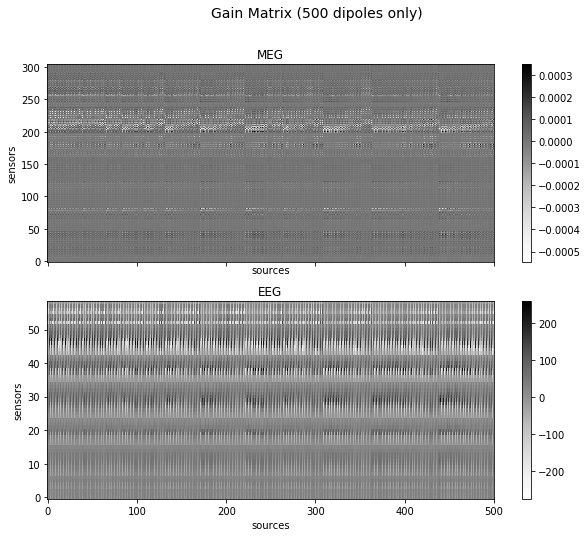

In [5]:
leadfield = forward['sol']['data']
picks_meg = mne.pick_types(forward['info'], meg=True, eeg=False)
picks_eeg = mne.pick_types(forward['info'], meg=False, eeg=True)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
fig.suptitle('Gain Matrix (500 dipoles only)', fontsize=14)
for ax, picks, ch_type in zip(axes, [picks_meg, picks_eeg], ['meg', 'eeg']):
    im = ax.imshow(leadfield[picks, :500], origin='lower', aspect='auto',
                   cmap='Greys')
    ax.set_title(ch_type.upper())
    ax.set_xlabel('sources')
    ax.set_ylabel('sensors')
    plt.colorbar(im, ax=ax, cmap='Greys')
plt.show()

We now have the Gain Matrix and the M/EEG data from the forward solution. Additionally we have the covariance matrix that will help us find the correct weighting per sensor. The weights are given in **stc_dspm**. We don't focus on this section of finding the weights themselves.

In [6]:
alpha = 40  # general regularization parameter
l1_ratio = 0.03  # temporal regularization parameter
loose, depth = 0.2, 0.9  # loose orientation & depth weighting

# Using the dynamic Statistical Parametric Map to solve for the weights assuming a GMM
inverse_operator = make_inverse_operator(evoked.info, forward, cov,
                                         loose=loose, depth=depth)
stc_dspm = apply_inverse(evoked, inverse_operator, lambda2=1. / 9.,
                         method='dSPM')

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 364 channels.
    Created an SSP operator (subspace dimension = 4)
estimated rank (mag + grad): 302
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
estimated rank (eeg): 58
Setting small EEG eigenvalues to zero.
Not doing PCA for EEG.
    Created the whitener using a noise covariance matrix with rank 360 (4 small eigenvalues omitted)
Creating the depth weighting matrix...
    203 planar channels
    limit = 7262/7498 = 10.020865
    scale = 2.58122e-08 exp = 0.9
Computing inverse operator with 364 channels.
Creating the source covariance matrix
Applying loose dipole orientations. Loose value of 0.2.
Whitening the forward solution.
Adjusting source cov

In [7]:
print stc_dspm
print evoked

<SourceEstimate  |  7498 vertices, subject : sample, tmin : -99.8976065792 (ms), tmax : 399.5904263167758 (ms), tstep : 1.66496010965 (ms), data shape : (7498, 301)>
<Evoked  |  'Left visual' (mean, N=64), [-0.099898, 0.39959] sec, 374 ch, ~4.5 MB>


### Timing different convergence algorithms and Active Set Cardinality

In [21]:
# %%timeit
# dipoles, residual = mixed_norm(
#     evoked, forward, cov, alpha=alpha, l1_ratio=l1_ratio, loose=loose,
#     depth=depth, maxit=200, tol=1e-6, weights=stc_dspm, weights_min=8.,
#     debias=True, wsize=16, tstep=4, window=0.05, return_as_dipoles=True,
#     return_residual=True)

stc = mixed_norm(evoked, forward, cov, alpha, loose=loose, depth=depth,
               maxit=3000, tol=1e-6, active_set_size=10, pca=None,
               debias=True, time_pca=True, weights=None, weights_min=8.,
               solver='prox', n_mxne_iter=5, return_residual=False,
               return_as_dipoles=True, dgap_freq=10, verbose = True)

print

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 364 channels.
    Created an SSP operator (subspace dimension = 4)
estimated rank (mag + grad): 302
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
estimated rank (eeg): 58
Setting small EEG eigenvalues to zero.
Not doing PCA for EEG.
    Created the whitener using a noise covariance matrix with rank 360 (4 small eigenvalues omitted)
Whitening lead field matrix.
Applying loose dipole orientations. Loose value of 0.2.
Whitening data matrix.
-- ALPHA MAX : 100.0
Using proximal iterations
Iteration 1 :: p_obj 4805.396886 :: dgap 168.652944 ::n_active_start 10 :: n_active_end 3
Iteration 2 :: p_obj 4799.178314 :: dgap 0.000001 ::n_active_start 13 :: n_act

For more information on the SSP operator and the noise reduction techniques used consult the citations provided up top. The dipoles for each epoch have now been extracted and the results can be plotted. **Note: The active set for left visual stimulus has 3 dipoles. This result is the structured and sparse solution across time and across channels**

[<Dipole  |  n_times : 301, tmin : -0.100, tmax : 0.400>, <Dipole  |  n_times : 301, tmin : -0.100, tmax : 0.400>, <Dipole  |  n_times : 301, tmin : -0.100, tmax : 0.400>, <Dipole  |  n_times : 301, tmin : -0.100, tmax : 0.400>, <Dipole  |  n_times : 301, tmin : -0.100, tmax : 0.400>, <Dipole  |  n_times : 301, tmin : -0.100, tmax : 0.400>, <Dipole  |  n_times : 301, tmin : -0.100, tmax : 0.400>]
0


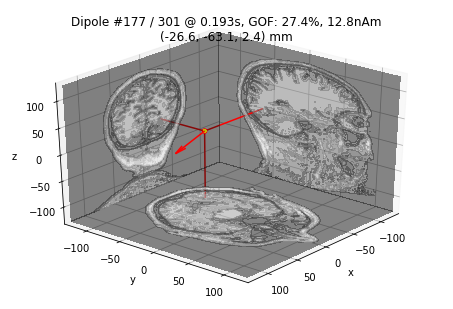

1


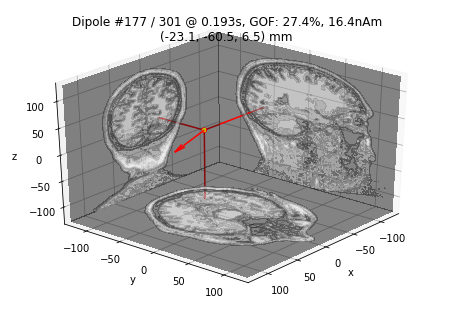

2


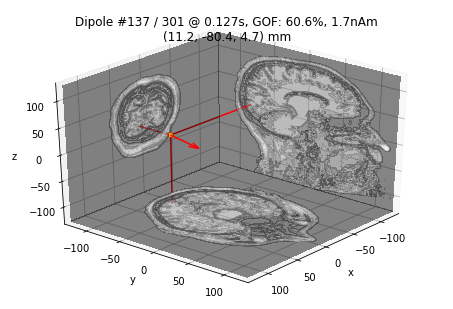

3


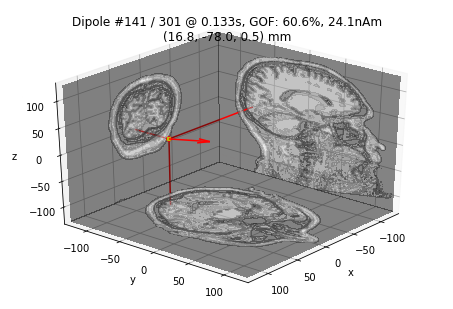

4


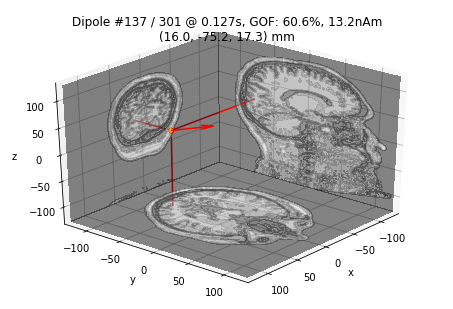

5


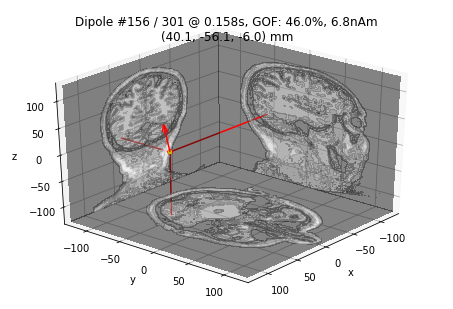

6


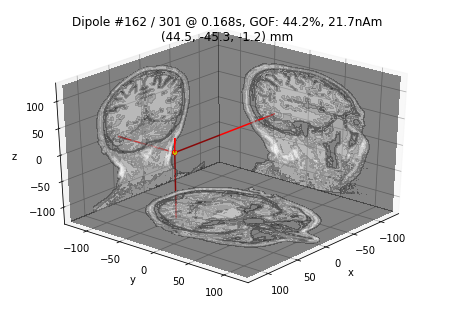

In [18]:
# Plot dipole locations of all dipoles with MRI slices
print stc
i = 0
for dip in stc:
    print i
    plot_dipole_locations(dip, forward['mri_head_t'], 'sample',
                          subjects_dir=subjects_dir, mode='orthoview',
                          idx='amplitude')
    i = i + 1

### Results of Varying the Active Set and Solver of the Formulated Convex Optimization Problem

The prox-FISTA approach with a varied Active Set was considered here to analyze the impact of the size of the Active Set on the convergence speed. The results are shown below, with all other parameters constant as shown in the code above.

Text(0.5,1,'Convergence times as a function of the size of the active set')

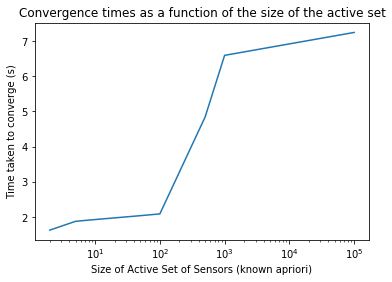

In [51]:
# Extracted from the above code
x = [2,5,10,50,100,500,1000,100000]
y = [1.63,1.88,1.93,2.04,2.09,4.84,6.59,7.24]
plt.plot(x,y)
plt.xscale('log')
plt.xlabel("Size of Active Set of Sensors (known apriori)")
plt.ylabel("Time taken to converge (s)")
plt.title("Convergence times as a function of the size of the active set")

Next the solvers are compared to among CD, GCD, FISTA, and AS-FISTA to find the quickest solver for the convex problem. FISTA performs worst but the other solvers are pretty comparable.

Text(0.5,1,'Convergence times as a function of the method')

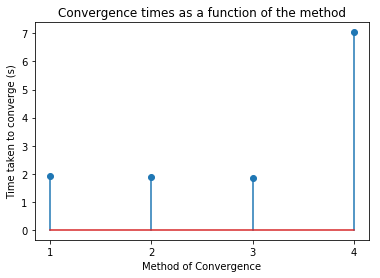

In [130]:
# Extracted from the above code
x_d = [1,2,3,4]
x = ["AS-FISTA(1)", "BLK Descent(2)", "Coord. Descent(3)", "FISTA(4)"]
y = [1.93,1.88,1.84,7.04]
plt.stem(x_d,y)
#plt.xticks(range(len(x_d)), x, size='small')
plt.xticks(x_d)
plt.xlabel("Method of Convergence")
plt.ylabel("Time taken to converge (s)")
plt.title("Convergence times as a function of the method")

### Results of Varying the Time Frame, i.e disabling the "structure" of sparse time-invariant dipoles

By shrinking the time dimension of the matrix, we disable structure and remove the effect of the 2-norm. This experiment shows the importance of the L-21 norm regularizer as a trade-off against the simple L1-norm. The lack of causal expression in succeeding time stamps results in **high cardinality of the active set**. The window in these experiments are asymmetric across the epochs, with the same distribution as the proposed window and for a fixed weight.

Furthermore, it is expected that the active set goes up to a certain number of samples and then drops to the correct minima. This is because for smaller number of time samples, the 2-norm applied across time does not do a good job at structuring the data. The L1-norm across space afterwards, creates more solutions to the sparsity. We also expect that toggling the regularization parameter will shift the graph below left or right depending on the intrinsic threshold.

Text(0.5,1,'The effect of sparsity on increased time samples per epoch')

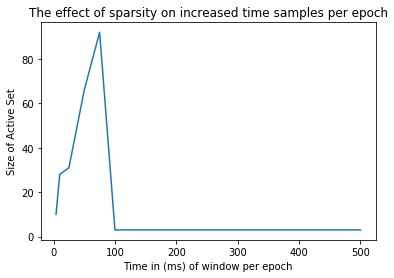

In [131]:
x = [4,10,25,50,75,100,125,250,500]
y = [10,28,31,66,92,3,3,3,3]
plt.plot(x,y)
#plt.xscale('log')
plt.xlabel("Time in (ms) of window per epoch")
plt.ylabel("Size of Active Set")
plt.title("The effect of sparsity on increased time samples per epoch")